In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

In [3]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_mujoco_ant',
 'd4rl_mujoco_halfcheetah',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiab

In [4]:
#------------- Download data from Laurence Moroney

DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [5]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)


Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [6]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

# For Mobilenet v2 possible input sizes are [96, 128, 160, 192, 224].
INPUT_IMG_SIZE_REDUCED = 128
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 128
Input image shape (reduced): (128, 128, 3)


Input image size: 128
Input image shape: (128, 128, 3)


In [7]:
get_label_name = dataset_info.features['label'].int2str

In [8]:
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


In [9]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

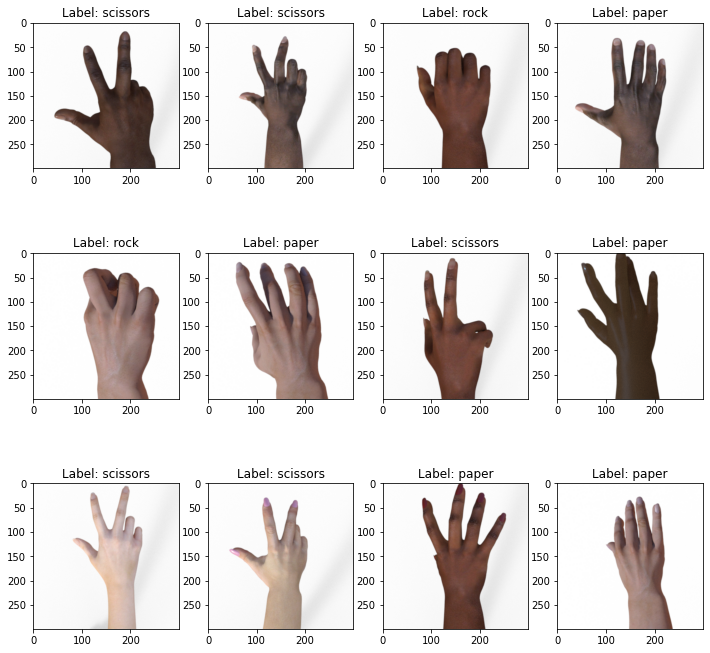

In [10]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [11]:
# Explore what values are used to represent the image.
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


In [12]:
#---------------Preprocess the data set
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [13]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [14]:
# Explore what values are used to represent the image.
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (128, 128, 3) 

[[[0.99521387 0.99521387 0.99521387]
  [0.99607843 0.99607843 0.99607843]
  [0.9939281  0.9939281  0.9939281 ]
  ...
  [0.9838513  0.9838513  0.9838513 ]
  [0.9856216  0.9856216  0.9856216 ]
  [0.98129785 0.98129785 0.98129785]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9960181  0.9960181  0.9960181 ]
  [0.99601716 0.99601716 0.99601716]
  ...
  [0.9818407  0.9818407  0.9818407 ]
  [0.984375   0.984375   0.984375  ]
  [0.98169994 0.98169994 0.98169994]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.9953719  0.9953719  0.9953719 ]
  ...
  [0.9859232  0.9859232  0.9859232 ]
  [0.98425245 0.98425245 0.98425245]
  [0.97992975 0.97992975 0.97992975]]

 ...

 [[0.98749423 0.98749423 0.98749423]
  [0.9882133  0.9882133  0.9882133 ]
  [0.986736   0.986736   0.986736  ]
  ...
  [0.972549   0.972549   0.972549  ]
  [0.97391427 0.97391427 0.97391427]
  [0.9755237  0.9755237  0.9755237 ]]

 [[0.9907878  0.9907878  0.9907878

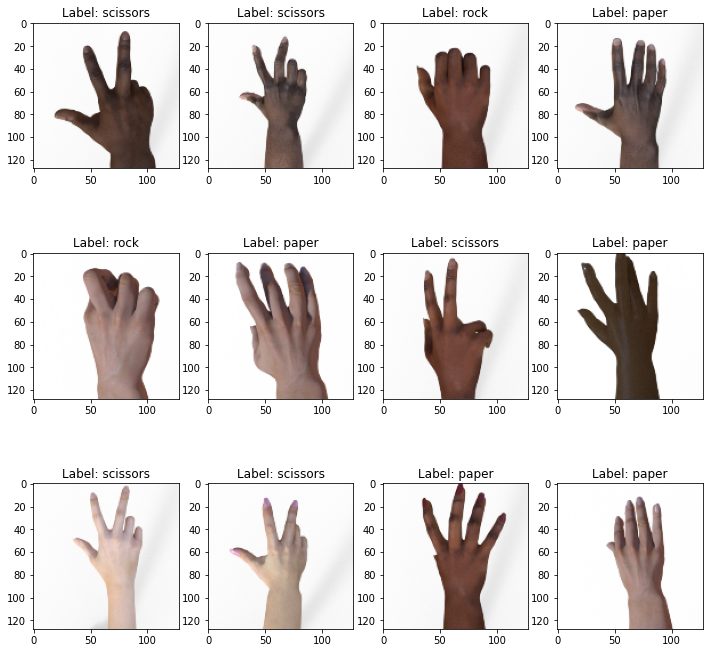

In [15]:
# Explore preprocessed training dataset images.
preview_dataset(dataset_train)

In [16]:
#----------------------Data Augmentation. Deal with differing backgrounds
#---------------------- vertical positioning, different races and so on.

In [17]:
#------------------flip

def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [18]:
#  ----------------Augment colour
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [19]:
# ----------------rotate images
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [20]:
#  -----------------inverse images
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [21]:
#  ------------------zoom and crop
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [22]:
# ---------------Augment the data set
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [23]:
# ----------------map augmented data set into read data
dataset_train_augmented = dataset_train.map(augment_data)

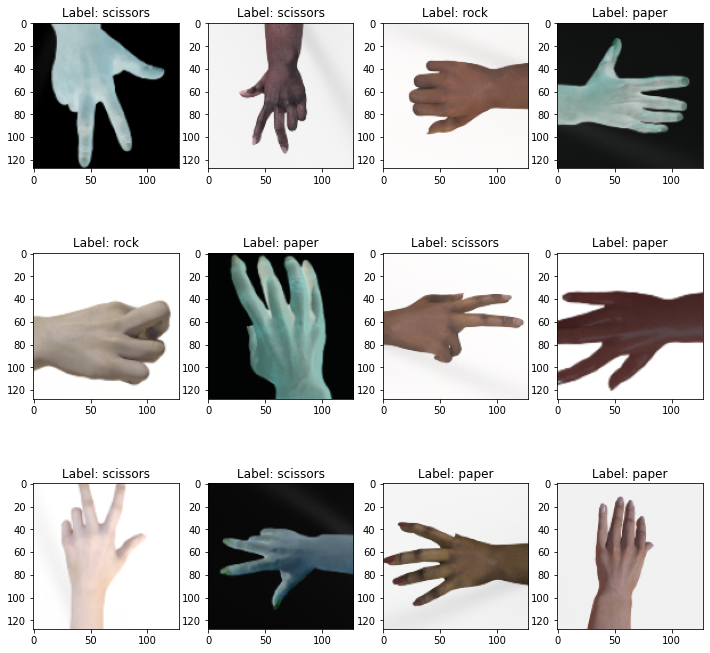

In [24]:
#Explore the training set
preview_dataset(dataset_train_augmented)

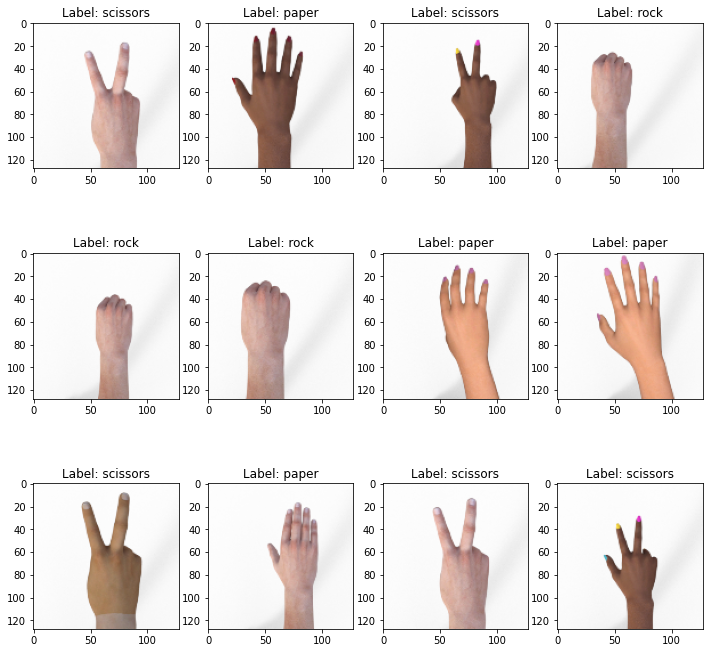

In [25]:
# Explore data set
preview_dataset(dataset_test)

In [26]:
#------------------shuffle the dta st so nothing will be learnt of the order,
#------------------split the batches to make it less time consuming

BATCH_SIZE = 800

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [27]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


Label batch shape: (800,) 

Image batch shape: (800, 128, 128, 3) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0 2 2 2 0 1
 2 1 0 0 0 0 0 1 1 2 2 0 0 2 1 1 0 0 1 2 1 0 0 0 0 1 2 1 1 2 2 1 1 1 1 1 2
 0 0 2 1 0 1 0 0 1 1 1 1 2 1 1 0 0 2 2 1 0 0 1 1 2 1 1 0 0 0 2 0 0 1 1 2 0
 2 0 1 1 1 2 0 1 0 1 2 1 0 1 2 2 0 2 1 0 0 1 0 1 0 1 2 1 2 2 1 0 2 0 1 1 2
 0 2 2 1 0 1 2 2 1 1 0 2 0 0 1 1 0 1 2 2 0 0 2 1 1 0 1 2 0 1 1 1 2 0 2 1 2
 1 1 1 2 2 2 1 0 2 0 1 0 1 2 0 0 2 0 1 1 0 2 2 2 1 1 1 0 1 0 2 0 0 1 1 1 2
 1 2 1 2 2 0 2 1 0 1 0 0 2 1 1 0 2 2 2 0 1 1 1 2 0 1 0 2 1 1 2 1 2 2 0 1 2
 2 0 2 1 0 2 0 0 1 0 2 2 0 0 2 2 0 0 2 2 1 0 0 0 2 1 1 0 2 0 1 1 1 2 1 1 0
 1 1 2 2 2 1 2 0 0 0 2 0 2 0 0 0 0 2 2 0 1 0 0 1 1 0 1 1 0 2 1 0 2 0 1 1 0
 2 1 0 0 1 2 2 0 1 1 2 2 2 0 2 2 2 0 2 1 2 0 2 1 0 1 1 1 0 2 0 1 0 1 0 0 0
 0 1 2 1 0 2 2 0 2 2 2 1 2 1 2 0 1 0 0 0 1 1 1 1 1 2 1 1 1 0 1 0 2 0 0 1 0
 0 2 0 0 1 1 1 1 2 2 2 1 1 0 1 2 0 1 2 0 0 1 1 0 2 2 1 2 2 1 1 0 2 1 2 2 0
 1 0 0 1 2 0 2 1 1 

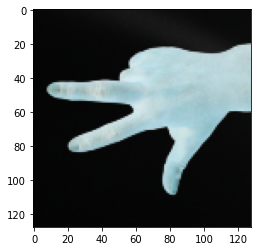

In [28]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')

    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

In [29]:
# --------Load the model and set the trainable to false
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  weights='imagenet',
  pooling='avg'
)

base_model.trainable = False

In [30]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

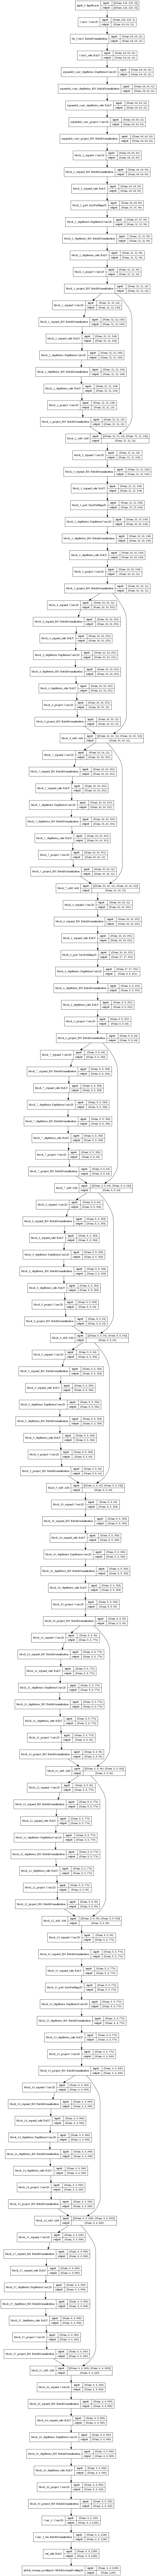

In [31]:
tf.keras.utils.plot_model(
    base_model,
    show_shapes=True,
    show_layer_names=True,
)

In [32]:
# -------------Add a classification head
model = tf.keras.models.Sequential()

model.add(base_model)

# model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


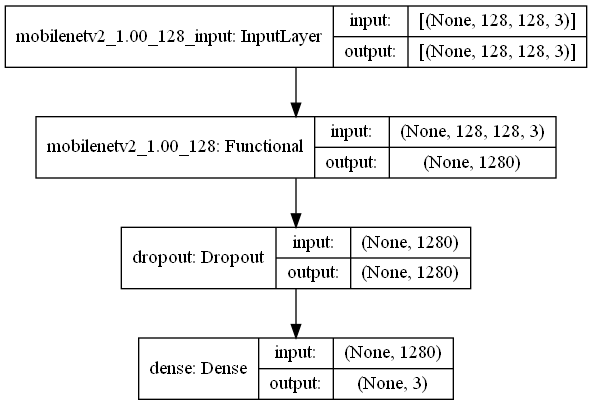

In [34]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [35]:
# --------------Complile the model
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [37]:
# -----------train the

steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 3
validation_steps: 1


In [39]:
# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [40]:
initial_epochs = 20

In [41]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/20
3/3 [==============================] - 50s 14s/step - loss: 1.8100 - accuracy: 0.3212 - val_loss: 1.0175 - val_accuracy: 0.5376
Epoch 2/20
3/3 [==============================] - 39s 19s/step - loss: 1.2720 - accuracy: 0.4680 - val_loss: 0.9470 - val_accuracy: 0.5538
Epoch 3/20
3/3 [==============================] - 35s 12s/step - loss: 1.0812 - accuracy: 0.5520 - val_loss: 0.7930 - val_accuracy: 0.7285

In [42]:

def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

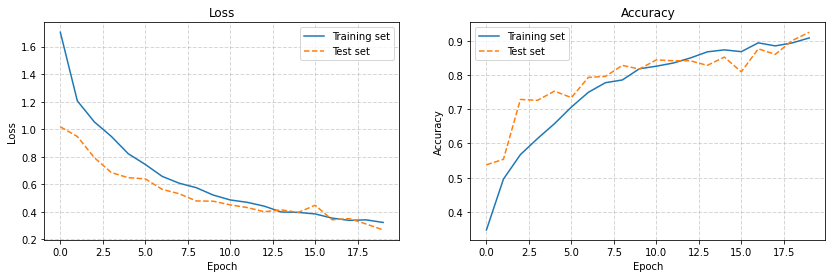

In [43]:
render_training_history(training_history)

In [44]:
#  ------------Fine tine the model by unfreezing the top layers of the base model
# Un-freeze the top layers of the model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [46]:
# Fine tune from this layer onwards.
fine_tune_at = 149

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# Compile the model using a much-lower training rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
    optimizer = rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 723,843
Non-trainable params: 1,537,984
_________________________________________________________________


In [47]:
# The number of additional epochs during which we're going to fine tune the model.
fine_tuning_epochs = 10

In [48]:
training_history_fine = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs + fine_tuning_epochs,
    initial_epoch=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback],
    verbose=1
)

Epoch 21/30
3/3 [==============================] - 40s 12s/step - loss: 0.2484 - accuracy: 0.9316 - val_loss: 0.1978 - val_accuracy: 0.9516
Epoch 22/30
3/3 [==============================] - 27s 13s/step - loss: 0.1580 - accuracy: 0.9718 - val_loss: 0.1897 - val_accuracy: 0.9570
Epoch 23/30
3/3 [==============================] - 24s 8s/step - loss: 0.1273 - accuracy: 0.9805 - val_loss: 0.2359 - val_accuracy: 0.9220

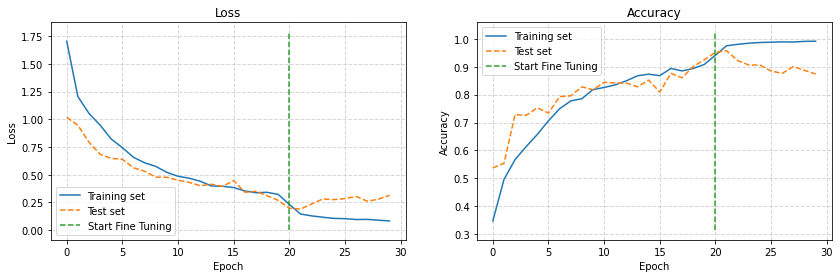

In [50]:
# ------------show graph of epoch against loss, and epoch against accuracy

loss = training_history.history['loss'] + training_history_fine.history['loss']
val_loss = training_history.history['val_loss'] + training_history_fine.history['val_loss']

accuracy = training_history.history['accuracy'] + training_history_fine.history['accuracy']
val_accuracy = training_history.history['val_accuracy'] + training_history_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs],
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs],
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

In [51]:
# ----------evaluate model accuracu
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

1/1 [==============================] - 4s 4s/step - loss: 0.3146 - accuracy: 0.8737


In [ ]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

In [ ]:
# ---------- save model as  keras h5 file
model_name = 'rps_model.h5'
model.save(model_name, save_format='h5')